<a href="https://colab.research.google.com/github/nudojacopo/Conversation_dynamics/blob/main/src/SYN/focus/saturation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
import json
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

Cloning into 'thesis'...
remote: Enumerating objects: 1841, done.
remote: Counting objects: 100% (568/568), done.
remote: Compressing objects: 100% (272/272), done.
remote: Total 1841 (delta 351), reused 474 (delta 293), pack-reused 1273
Receiving objects: 100% (1841/1841), 81.89 MiB | 11.90 MiB/s, done.
Resolving deltas: 100% (1172/1172), done.
Mounted at /content/drive


In [2]:
import pandas as pd

# Load the data
fb = pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_news_PRO.csv')
rd = pd.read_csv('/content/drive/MyDrive/thesis/data/reddit/reddit_PRO.csv')
vo = pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_PRO.csv')
gb = pd.read_csv('/content/drive/MyDrive/thesis/data/gab/gab_PRO.csv')

## Prepare Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import to_hex, LinearSegmentedColormap
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

# Define your color map here
colors = shades[::-1]

# Define platform names
platform_names = [
    'Facebook News - 2010', 'Facebook News - 2011', 'Facebook News - 2012',
    'Facebook News - 2013', 'Facebook News - 2014', 'Facebook News - 2015'
]

# Create a dictionary to map platform names to colors
color_map = dict(zip(platform_names, colors))

# Plot for Facebook News
fb_data = [
    fb2010o_M1, fb2011o_M1, fb2012o_M1, fb2013o_M1, fb2014o_M1, fb2015o_M1
]
for df in fb_data:
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df['sequential_position'] = df.groupby('post_id')['temporal_distance_birth_base_100h'].rank(method='first')
    num_bins = 20
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1
    df['first_comment'] = df['sequential_number_of_comment_by_user_in_thread'] == 1
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    df['bin_of_position']=df['bin_of_position']
agg_activity_obs = pd.concat([df.assign(platform=f'Facebook News - {year}') for df, year in zip(fb_data, range(2010, 2016))])
agg_activity_obs = agg_activity_obs.groupby(['Platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=agg_activity_obs,
    x='bin_of_position',
    y='first_comment',
    hue='Platform',
    palette=color_map,
    estimator='mean',
    errorbar=('ci', 95),
    linewidth=3
)

# Customize ticks and formatting
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure x-axis ticks are integers
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Round y-axis values to 2 decimal places

plt.ylabel('Share of First Comments', fontsize=16)
plt.xlabel('Bin of Position', fontsize=16)
plt.grid(False)
plt.ylim(0.3, 1)
plt.show()


array([ 2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5, 12.5])

nu vs nc

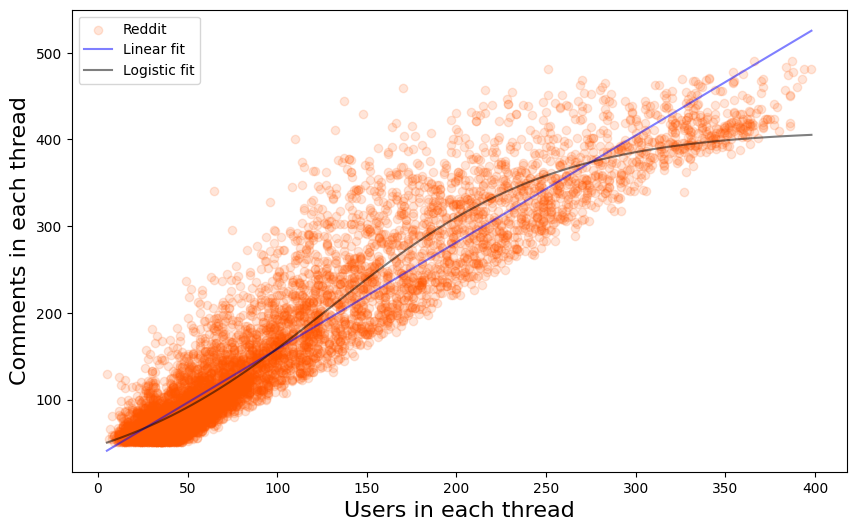

Linear fit AIC: 55927.61, BIC: 55941.50
Logistic fit AIC: 55143.63, BIC: 55164.47


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

# Assuming 'rd' DataFrame is already defined with 'post_id', 'user_id', and 'comment_id'

# Step 1: Create the series
nu = rd.groupby('post_id')['user_id'].unique()
nc = rd.groupby('post_id')['comment_id'].count()

# Step 2: Convert series to DataFrame
nu_df = nu.apply(len).reset_index(name='unique_users')  # Counting unique users
nc_df = nc.reset_index(name='comment_count')

# Step 3: Merge DataFrames on 'post_id'
merged_df = pd.merge(nu_df, nc_df, on='post_id')

# Step 5: Fit linear model
def linear_model(x, a, b):
    return a * x + b

popt_linear, pcov_linear = curve_fit(linear_model, merged_df['unique_users'], merged_df['comment_count'])

# Step 6: Fit logistic model
def logistic_model(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

popt_logistic, pcov_logistic = curve_fit(logistic_model, merged_df['unique_users'], merged_df['comment_count'], p0=[max(merged_df['comment_count']), 1, np.median(merged_df['unique_users'])])

# Step 7: Calculate AIC and BIC for each model
def calculate_aic(y, y_pred, num_params):
    resid = y - y_pred
    ss_resid = np.sum(resid**2)
    n = len(y)
    aic = n * np.log(ss_resid / n) + 2 * num_params
    return aic

def calculate_bic(y, y_pred, num_params):
    resid = y - y_pred
    ss_resid = np.sum(resid**2)
    n = len(y)
    bic = n * np.log(ss_resid / n) + num_params * np.log(n)
    return bic

# Predictions
y_pred_linear = linear_model(merged_df['unique_users'], *popt_linear)
y_pred_logistic = logistic_model(merged_df['unique_users'], *popt_logistic)

# Calculate AIC and BIC
aic_linear = calculate_aic(merged_df['comment_count'], y_pred_linear, len(popt_linear))
bic_linear = calculate_bic(merged_df['comment_count'], y_pred_linear, len(popt_linear))
aic_logistic = calculate_aic(merged_df['comment_count'], y_pred_logistic, len(popt_logistic))
bic_logistic = calculate_bic(merged_df['comment_count'], y_pred_logistic, len(popt_logistic))

# Step 8: Visualize fit and compare models
x_values = np.linspace(min(merged_df['unique_users']), max(merged_df['unique_users']), 100)

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['unique_users'], merged_df['comment_count'], label='Reddit', color='#FF5700', alpha=0.15)
plt.plot(x_values, linear_model(x_values, *popt_linear), label='Linear fit',color='blue', alpha=0.5)
plt.plot(x_values, logistic_model(x_values, *popt_logistic), label='Logistic fit', color='black' ,alpha=0.5)
plt.xlabel('Users in each thread', fontsize=16)
plt.ylabel('Comments in each thread', fontsize=16)
plt.legend()

plt.show()

# Print AIC and BIC
print("Linear fit AIC: {:.2f}, BIC: {:.2f}".format(aic_linear, bic_linear))
print("Logistic fit AIC: {:.2f}, BIC: {:.2f}".format(aic_logistic, bic_logistic))


Alpha vs Audience

<ipython-input-28-a1ce761d3065>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels(summary['N_binned_str'], rotation=45)
<ipython-input-28-a1ce761d3065>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels(summary['N_binned_str'], rotation=45)
<ipython-input-28-a1ce761d3065>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels(summary['N_binned_str'], rotation=45)
<ipython-input-28-a1ce761d3065>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[idx].set_xticklabels(summary['N_binned_str'], rotation=45)


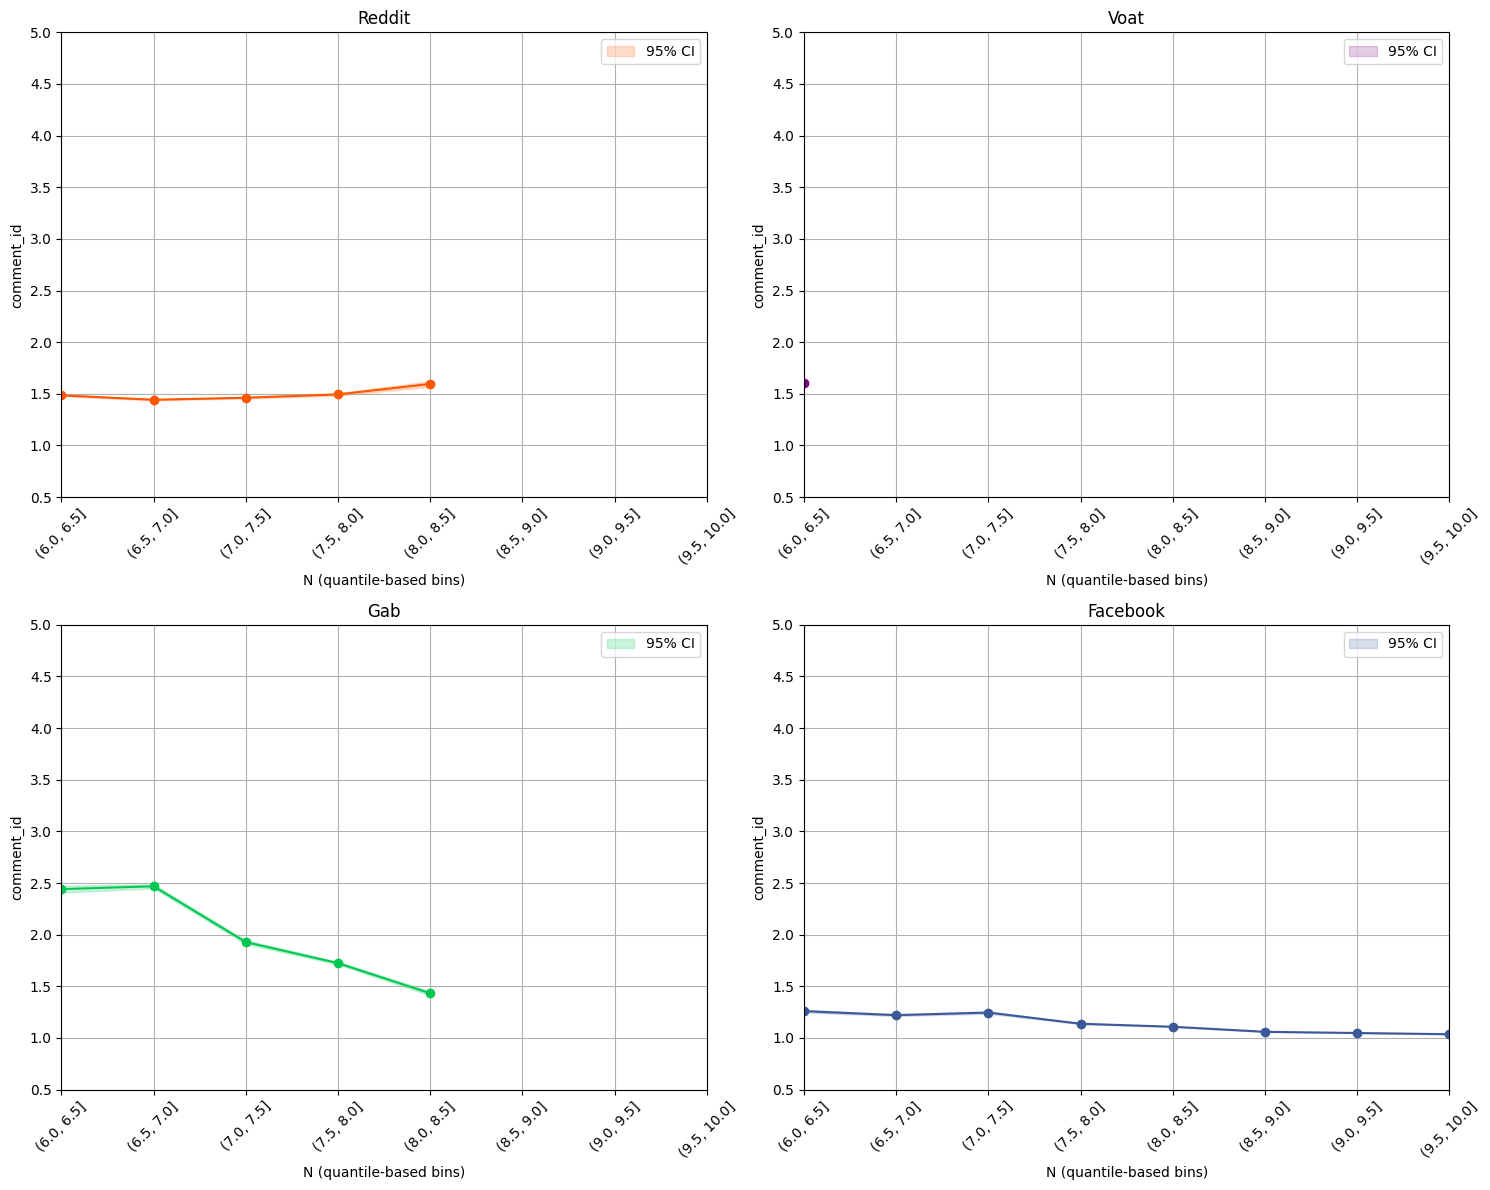

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the color palette
palette = {
    'Reddit': '#FF5700',   # Reddit orange
    'Voat': '#800080',     # Voat purple
    'Facebook': '#3b5998', # Facebook blue
    'Gab': '#00c853'       # Gab green
}

# Lista dei DataFrame e dei titoli dei grafici
dfs = [rd, vo, gb, fb]
titles = ['Reddit', 'Voat', 'Gab', 'Facebook']

# Configura la figura e gli assi per il layout 2x2
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs = axs.flatten()  # Facilita l'accesso agli assi


for idx, df in enumerate(dfs):
    h = 1000  # Definisci il valore corretto di h
    df = filter_first_h(dfs[idx], h)

    # Controllo per valori NaT in 'thread_birth'
    df['month-year'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d')

    # Conteggio degli utenti unici per 'month-year'
    df['N'] = df.groupby(['month-year', 'topic'])['user_id'].transform('nunique')
    alpha = df.groupby(['post_id', 'user_id', 'N'])['comment_id'].count().reset_index()
    alpha['N']=np.log(alpha['N'])
    bins = np.arange(2, 15.5, 0.5)  # Nota: 10.5 per includere l'ultimo valore 10

    # Applica pd.cut per assegnare i dati ai bin definiti
    alpha['N_binned'] = pd.cut(alpha['N'], bins=bins, include_lowest=True)
    # Calculate summary statistics
    summary = alpha.groupby('N_binned')['comment_id'].agg(['mean', 'count', 'std'])
    summary['ci'] = 1.96 * (summary['std'] / np.sqrt(summary['count']))  # 95% confidence interval

    # Convert intervals to strings for plotting
    summary.reset_index(inplace=True)
    summary['N_binned_str'] = summary['N_binned'].astype(str)

    # Plotting
    axs[idx].plot(summary['N_binned_str'], summary['mean'], marker='o', linestyle='-', color=palette[titles[idx]])
    axs[idx].fill_between(summary['N_binned_str'],
                          summary['mean'] - summary['ci'],
                          summary['mean'] + summary['ci'],
                          color=palette[titles[idx]], alpha=0.2, label='95% CI')
    axs[idx].set_xticklabels(summary['N_binned_str'], rotation=45)
    axs[idx].set_title(titles[idx])
    axs[idx].set_xlabel('N (quantile-based bins)')
    axs[idx].set_ylabel('comment_id')
    axs[idx].set_xlim(2,11)
    axs[idx].set_ylim(0.5,5)
    axs[idx].grid(True)
    axs[idx].legend()

# Aggiungi un layout migliore per i sottotitoli e la figura
plt.tight_layout()
plt.show()


In [ ]:
alpha['N'].max()

12.325183687884076